## ARISE-1.5 in the cloud - using kerchunck to improve access

In this notebook we use the kerchunk package to demonstrate a method of speeding up access to the ARISE-1.5 simulations hosted in the cloud on AWS. 

The motivation for using kerchunk is that these simulations, while available on the cloud, are not cloud-native format, such as zarr.  

By creating and then caching metadata reference files using kerchunk, we can speed up the process of working with the data. 

This notebook has several sections:
1. produce metadata jsons using kerchunk for a quick example set of data from the AWS ARISE simulations store - the monthly TREFHT outputs for 10 members. This takes a few minutes to process.
2. demonstrate usage of the kerchunked metadata by comparing time to make a plot of one region and time slice using the kerchunk approach versus directly reading in the files from AWS.
3. Repeat (1), this time for a weightier bit of data, the daily temperature outputs.
4. repeat (2) on these daily tempereature outputs. 

The code in this notebook draws heavily on Lucas Sterzinger's tutorial here: 
https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685


We also use some code from the docs here:
https://fsspec.github.io/kerchunk/tutorial.html

Note the "environment.yml" file, which can be used to build the needed python environment.


In [22]:
# imports
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import logging
import fsspec
import ujson
from tqdm import tqdm
from glob import glob
import warnings
warnings.filterwarnings("ignore") # dask custers prints a lot of warmings to screen
fs = fsspec.filesystem('s3', anon=True)

### Part 1: generate the JSONs
This part is only needed the first time, or can be skipped entirely by downloading our output JSON file. For this test case using monthly data, it only takes around 30 seconds, but in general it can be slow, since the process involves opening and reading lots of .nc files. The time taken for this process is an order of magnitude estimate of the time saved by doing it, each time the pseduo-zarr dataset is used. 

In [23]:
var = 'TREFHT' # use surface temp for this example

In [24]:
# define a set of urls corresponding to some part of the ARISE-1.5 data set on AWS
# here we use globbing to get all 10 ensemble members of the monthly near-surface air temperature

urls = ['s3://' + f for f in fs.glob("s3://"+"ncar-cesm2-arise/ARISE-SAI-1.5/*/atm/proc/*/month_1/*{}.*.nc".format(var))]
urls

['s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005.cam.h0.TREFHT.203501-206912.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.

In [4]:
# start a dask client to open and process in parallel
import dask
from dask.distributed import Client
client = Client(n_workers=10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 20,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45937,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:37939,Total threads: 2
Dashboard: http://127.0.0.1:39551/status,Memory: 2.40 GiB
Nanny: tcp://127.0.0.1:33109,


2025-02-10 10:42:28,783 - distributed.scheduler - WARNING - Worker failed to heartbeat for 477s; attempting restart: <WorkerState 'tcp://127.0.0.1:33105', name: 5, status: running, memory: 0, processing: 1>
2025-02-10 10:42:28,788 - distributed.scheduler - WARNING - Worker failed to heartbeat for 476s; attempting restart: <WorkerState 'tcp://127.0.0.1:42321', name: 8, status: running, memory: 0, processing: 1>
2025-02-10 10:42:32,799 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-10 10:42:32,801 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-10 10:42:32,845 - distributed.nanny - WARNING - Restarting worker
2025-02-10 10:42:32,848 - distributed.nanny - WARNING - Restarting worker


In [7]:
# generate 1 json file per .nc file, each json contains the metadata for that .nc
def gen_json(u):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False,
        default_cache_type="none"
    )
    with fsspec.open(u, **so, expand=True) as inf:
        h5chunks = SingleHdf5ToZarr(inf, u, inline_threshold=300)
        with open(f"jsons_monthly/{u.split('/')[-1]}.json", 'wb') as outf:
           outf.write(ujson.dumps(h5chunks.translate()).encode())
    print(u)

In [8]:
# run over the file list:

import pathlib
pathlib.Path('./jsons_monthly/').mkdir(exist_ok=True)
dask.compute(*[dask.delayed(gen_json)(u) for u in urls])

s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.006/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.006.cam.h0.TREFHT.203501-206912.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h0.TREFHT.203501-206912.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.007/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.007.cam.h0.TREFHT.203501-206912.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.010/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.010.cam.h0.TREFHT.203501-206912.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005.cam.h0.TREFHT.203501-206912.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-

(None, None, None, None, None, None, None, None, None, None)

In [9]:
# we extract the ensemble member label from the filename - a bit of a hack
def fn_to_time(index, fs, var, fn):
    import re
    ex = re.compile(r'\.(\d{3})\.cam')
    return ex.search(fn).group(1)

In [10]:
## combine jsons into one:
json_list = sorted(glob('./jsons_monthly/*.json'))

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {'Ensemble_member':fn_to_time},
    concat_dims=['Ensemble_member', 'time'],
    identical_dims = ['lat', 'lon']
)


mzz.translate('./combined_monthly_TREFHT.json')

{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  'Ensemble_member/.zarray': '{\n    "chunks": [\n        10\n    ],\n    "compressor": null,\n    "dtype": "<U3",\n    "fill_value": "",\n    "filters": null,\n    "order": "C",\n    "shape": [\n        10\n    ],\n    "zarr_format": 2\n}',
  'Ensemble_member/0': '0\x00\x00\x000\x00\x00\x001\x00\x00\x000\x00\x00\x000\x00\x00\x002\x00\x00\x000\x00\x00\x000\x00\x00\x003\x00\x00\x000\x00\x00\x000\x00\x00\x004\x00\x00\x000\x00\x00\x000\x00\x00\x005\x00\x00\x000\x00\x00\x000\x00\x00\x006\x00\x00\x000\x00\x00\x000\x00\x00\x007\x00\x00\x000\x00\x00\x000\x00\x00\x008\x00\x00\x000\x00\x00\x000\x00\x00\x009\x00\x00\x000\x00\x00\x001\x00\x00\x000\x00\x00\x00',
  'Ensemble_member/.zattrs': '{\n    "_ARRAY_DIMENSIONS": [\n        "Ensemble_member"\n    ]\n}',
  'time/.zarray': '{\n    "chunks": [\n        432\n    ],\n    "compressor": {\n        "checksum": false,\n        "id": "zstd",\n        "level": 0\n    },\n    "dtype": "<f8",\n    

## Part 2: using our new metadata jsons

Execution time: 4.310861110687256 seconds


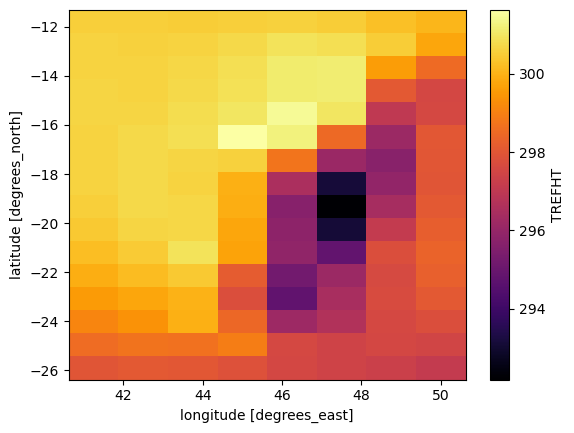

In [16]:
# lazy load open as a psuedo-zarr from the combined json:
# and plot
import time as timing
start_time = timing.time()

### START MAIN
fs = fsspec.filesystem(
    "reference", 
    fo="./combined_monthly_TREFHT.json", 
    remote_protocol="s3", 
    remote_options={"anon":True},
    skip_instance_cache=True
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine='zarr', backend_kwargs={'consolidated':False})

## pick a small region of the world and time-slice to plot
subset = ds.sel(lon=slice(41, 51),lat=slice(-26, -11), time=slice('2060', '2069')) 
subset.TREFHT.mean(['Ensemble_member', 'time']).plot(cmap='inferno')
### END MAIN

end_time = timing.time()
print(f"Execution time: {end_time - start_time} seconds")

#### repeat without kerchunk/zarr as a test of speed difference


Execution time: 24.53959035873413 seconds


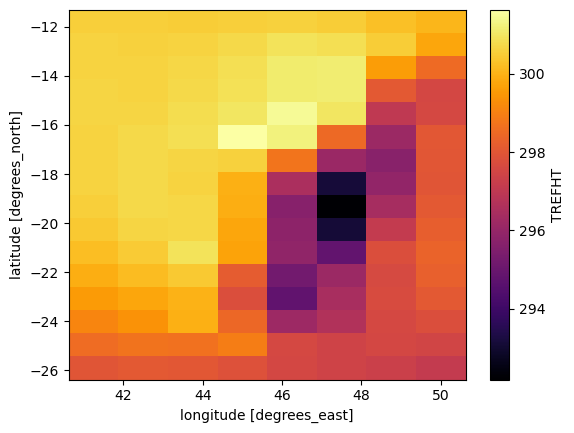

In [12]:
def get_trefht_data(scenario='ARISE'):
    da_list = []
    members = ['001', '002', '003', '004', '005', 
               '006', '007', '008', '009', '010']

    for member in members:
        locs = {'ARISE':'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}.cam.h0.TREFHT.*.nc'.format(m=member),
                'SSP245_1':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.*.nc'.format(m=member),
                'SSP245_2':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.*.nc'.format(m=member)}
        
        loc = locs[scenario]
        s3_path = "s3://" + loc
        # Open the dataset directly from the S3 URL using xarray
        with fsspec.open(s3_path, mode='rb', anon=True, expand=True) as file:
            da = xr.open_dataset(file, engine="h5netcdf")['TREFHT']
            da_list.append(da.load()) 
            # note that this takes a decent chunk of memory as we dont do anything clever with dask here            
    ds = xr.concat(da_list, dim='Ensemble_member').assign_coords({'Ensemble_member':members})       
    
    return ds

start_time = timing.time()

### START MAIN
ds2 = get_trefht_data(scenario='ARISE')
subset2 = ds2.sel(lon=slice(41, 51),lat=slice(-26, -11), time=slice('2060', '2069')) 
subset2.mean(['Ensemble_member', 'time']).plot(cmap='inferno')
### END MAIN

end_time = timing.time()
print(f"Execution time: {end_time - start_time} seconds")

## Repeat the whole process on daily data, to show a larger speed-up. 

This time we are saving our kerchunked jsons for the daily data, and as such the process is much (~30x) slower. On my machine, making the jsons takes ~ 20 minutes

In [25]:
# use daily data this time
# to save compute time, we do this only for the final five years of the run (files containing 2065)

urls = ['s3://' + f for f in fs.glob("s3://"+"ncar-cesm2-arise/ARISE-SAI-1.5/*/atm/proc/*/day_1/*TREFHT.*2065*.nc")]
urls

['s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h1.TREFHT.20650101-20691230.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002.cam.h1.TREFHT.20650101-20691231.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003.cam.h1.TREFHT.20650101-20691231.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h1.TREFHT.20650101-20691231.nc',
 's3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005.cam.h1.TREFHT.20650101-20691231.nc',
 's3://ncar-cesm2-arise/ARISE-

In [27]:
### NOTE: cell takes 10s of minutes to run! 

# generate 1 json file per .nc file, each json contains the metadata for that .nc
def gen_json(u):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False,
        default_cache_type="none"
    )
    with fsspec.open(u, **so, expand=True) as inf:
        h5chunks = SingleHdf5ToZarr(inf, u, inline_threshold=300)
        with open(f"jsons_daily/{u.split('/')[-1]}.json", 'wb') as outf:
           outf.write(ujson.dumps(h5chunks.translate()).encode())
    print(u)

# run over the file list:

import pathlib
pathlib.Path('./jsons_daily/').mkdir(exist_ok=True)
dask.compute(*[dask.delayed(gen_json)(u) for u in urls])

s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002.cam.h1.TREFHT.20650101-20691231.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.008/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.008.cam.h1.TREFHT.20650101-20691230.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003.cam.h1.TREFHT.20650101-20691231.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.006/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.006.cam.h1.TREFHT.20650101-20691231.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h1.TREFHT.20650101-20691231.nc
s3://ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g

(None, None, None, None, None, None, None, None, None, None)

In [28]:
## combine jsons into one mega json:
json_list = sorted(glob('./jsons_daily/*.json'))

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {'Ensemble_member':fn_to_time},
    concat_dims=['Ensemble_member', 'time'],
    identical_dims = ['lat', 'lon']
)


mzz.translate('./combined_daily_{}.json'.format(var))

{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  'Ensemble_member/.zarray': '{\n    "chunks": [\n        10\n    ],\n    "compressor": null,\n    "dtype": "<U3",\n    "fill_value": "",\n    "filters": null,\n    "order": "C",\n    "shape": [\n        10\n    ],\n    "zarr_format": 2\n}',
  'Ensemble_member/0': '0\x00\x00\x000\x00\x00\x001\x00\x00\x000\x00\x00\x000\x00\x00\x002\x00\x00\x000\x00\x00\x000\x00\x00\x003\x00\x00\x000\x00\x00\x000\x00\x00\x004\x00\x00\x000\x00\x00\x000\x00\x00\x005\x00\x00\x000\x00\x00\x000\x00\x00\x006\x00\x00\x000\x00\x00\x000\x00\x00\x007\x00\x00\x000\x00\x00\x000\x00\x00\x008\x00\x00\x000\x00\x00\x000\x00\x00\x009\x00\x00\x000\x00\x00\x001\x00\x00\x000\x00\x00\x00',
  'Ensemble_member/.zattrs': '{\n    "_ARRAY_DIMENSIONS": [\n        "Ensemble_member"\n    ]\n}',
  'time/.zarray': '{\n    "chunks": [\n        2191\n    ],\n    "compressor": {\n        "checksum": false,\n        "id": "zstd",\n        "level": 0\n    },\n    "dtype": "<f8",\n   

Now repeat the test from above, plotting one region, both using kerchunked metadata, and directly from the AWS file store. 

Execution time: 8.089061260223389 seconds


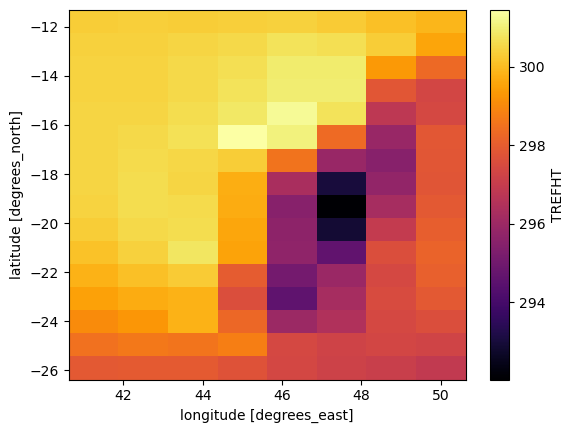

In [29]:
# lazy load open as a psuedo-zarr from the combined json:
# and plot
import time as timing
start_time = timing.time()

### START MAIN
fs = fsspec.filesystem(
    "reference", 
    fo="./combined_daily_TREFHT.json", 
    remote_protocol="s3", 
    remote_options={"anon":True},
    skip_instance_cache=True
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine='zarr', backend_kwargs={'consolidated':False})

## pick a small region of the world and a single year to plot
subset = ds.sel(lon=slice(41, 51),lat=slice(-26, -11), time=slice('2065')) 
subset.TREFHT.mean(['Ensemble_member', 'time']).plot(cmap='inferno')
### END MAIN

end_time = timing.time()
print(f"Execution time: {end_time - start_time} seconds")


Execution time: 250.13537764549255 seconds


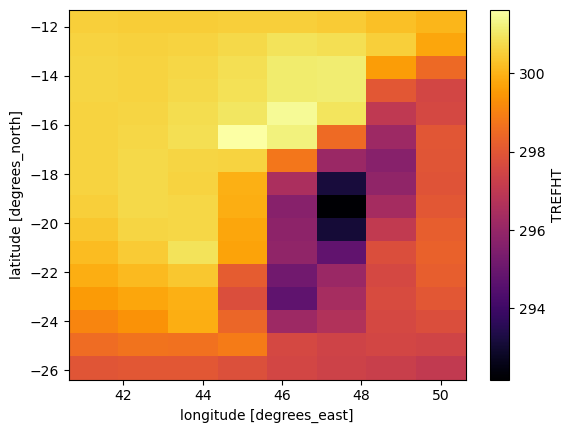

In [35]:
### now repeat without kerchunk/zarr, to show the much slower speed
def get_trefht_data(scenario='ARISE'):
    da_list = []
    members = ['001', '002', '003', '004', '005', 
               '006', '007', '008', '009', '010']

    for s3_path in urls:
        with fsspec.open(s3_path, mode='rb', anon=True, expand=True) as file:
            da = xr.open_dataset(file, engine="h5netcdf")['TREFHT']
            da_list.append(da.load()) 
            # note that this takes a decent chunk of memory as we dont do anything clever with dask here            
    ds = xr.concat(da_list, dim='Ensemble_member').assign_coords({'Ensemble_member':members})       
    
    return ds

start_time = timing.time()

### START MAIN
ds2 = get_trefht_data(scenario='ARISE')
subset2 = ds2.sel(lon=slice(41, 51),lat=slice(-26, -11), time=slice('2060', '2069')) 
subset2.mean(['Ensemble_member', 'time']).plot(cmap='inferno')
### END MAIN

end_time = timing.time()
print(f"Execution time: {end_time - start_time} seconds")

The above direct plotting takes 30 times longer than using the kerchunk metadata to shortcut the processing. It also uses about 5GB memory, as opposed to 100s MB for the kerchunk version. 

By using kerchunk to save metadata for our AWS archive locally, we reduced the time (and memory) to process the data substantially. 

While the initial kerchunking step was slow, we only need to do it once for a given variable or set of files. 

In [37]:
## remember to shutdown dask client!
client.shutdown()